# 2021-09-29 Handling stiffness

## Last time

* A and L stability
* transient advection
* transient heat equation

## Today

* Stability for advection-diffusion
* Cost scaling

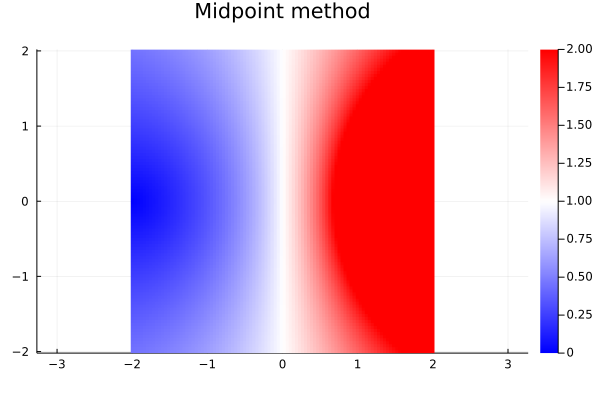

In [56]:
using Plots
using LinearAlgebra
using SparseArrays
using Zygote

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

# A $\theta$ solver

In [2]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

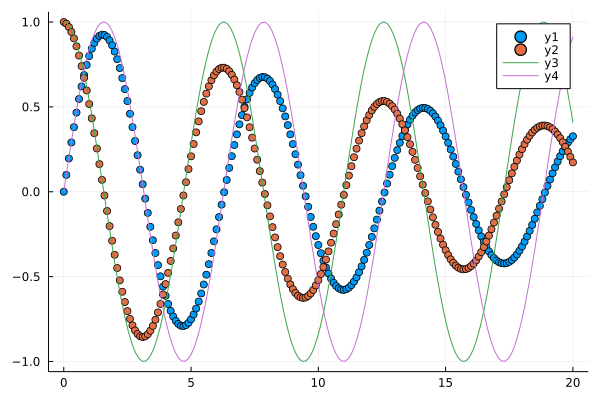

In [3]:
# Test on oscillator
A = [0 1; -1 0]
thist, uhist = ode_theta_linear(A, [0., 1], h=.1, theta=1, tfinal=20)
scatter(thist, uhist')
plot!([cos, sin])

# Stiff decay to cosine

$$\dot u = -k(u - \cos t) = -k u + k \cos t$$

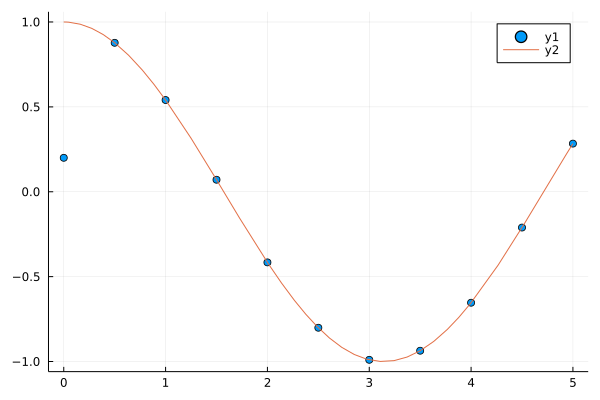

In [4]:
k = 10000
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.5, theta=1)
scatter(thist, uhist[1,:])
plot!(cos)

# Advection-diffusion as linear ODE

\begin{align}
(-\kappa u_x + w u)_x &= 0 & Pe_L &= \frac{L \lvert w \rvert}{\kappa}
\end{align}

In [66]:
function advdiff_matrix(n; kappa=1, wind=1, upwind=0.)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.(i-1:i+1))
        diffuse = [-1, 2, -1] * kappa / dx^2
        advect_upwind = [-1, 1, 0] * wind / dx
        advect_center = [-1, 0, 1] * wind / 2dx
        stencil = -diffuse - upwind * advect_upwind - (1 - upwind) * advect_center
        append!(vals, stencil)
    end
    sparse(rows, cols, vals)
end
advdiff_matrix(5, 1000)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -0.025   -1.2375    ⋅        ⋅       1.2625
  1.2625  -0.025   -1.2375    ⋅        ⋅ 
   ⋅       1.2625  -0.025   -1.2375    ⋅ 
   ⋅        ⋅       1.2625  -0.025   -1.2375
 -1.2375    ⋅        ⋅       1.2625  -0.025

  0.001004 seconds (2.19 k allocations: 2.237 MiB)


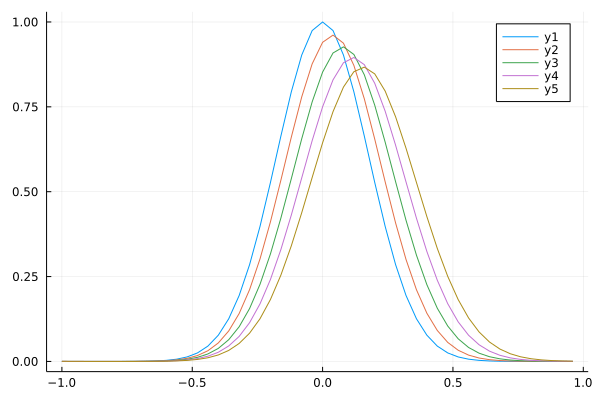

In [67]:
n = 50
A = advdiff_matrix(n, kappa=1/30, upwind=0)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-16 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5)
plot(x, uhist[:, 1:5])

# Explain the mechanism and obstacles to fixing

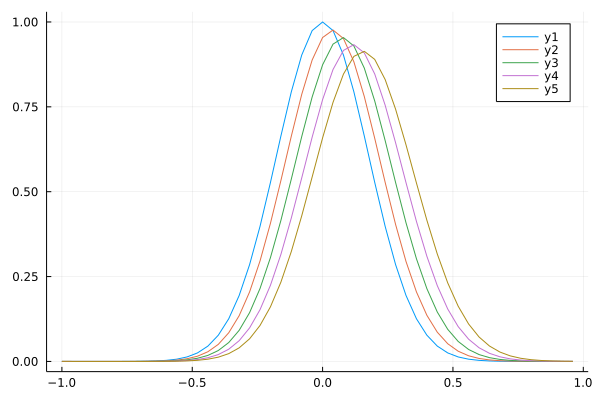

In [69]:
A = advdiff_matrix(50, kappa=.02, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5, tfinal=1.);
plot(x, uhist[:, 1:5])

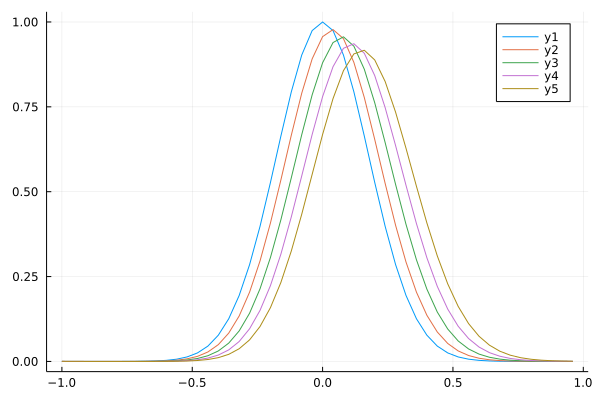

In [70]:
A = advdiff_matrix(50, kappa=0, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=1, tfinal=1.)
plot(x, uhist[:, 1:5])

# Explain the mechanism

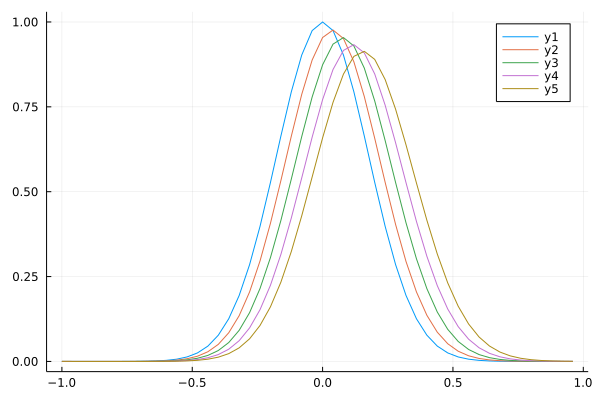

In [72]:
A = advdiff_matrix(50, kappa=.02, upwind=0)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5, tfinal=1.);
plot(x, uhist[:, 1:5])

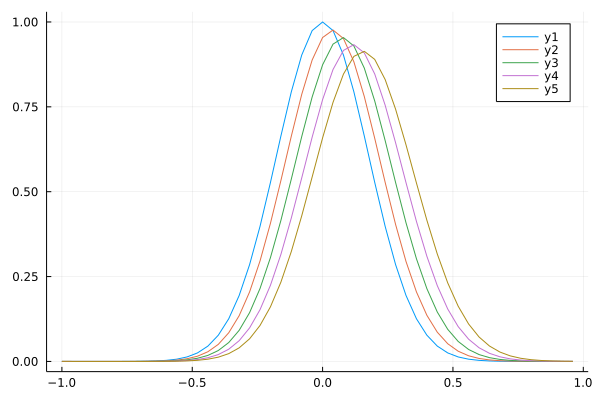

In [73]:
A = advdiff_matrix(50, kappa=0, upwind=1)
thist, uhist = ode_theta_linear(A, u0, h=.04, theta=.5, tfinal=1.)
plot(x, uhist[:, 1:5])

# Stability classes and the $\theta$ method


### Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

### Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

# A test problem

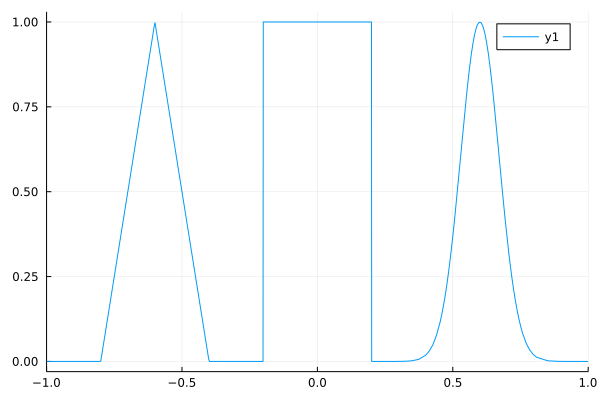

In [78]:
function initial_three(x)
    a = max(0, 1 - 5 * abs(x + .6))
    b = abs(x) < .2
    c = exp(-100 * (x - .6)^2)
    a + b + c
end
plot(initial_three, xlims=(-1, 1))

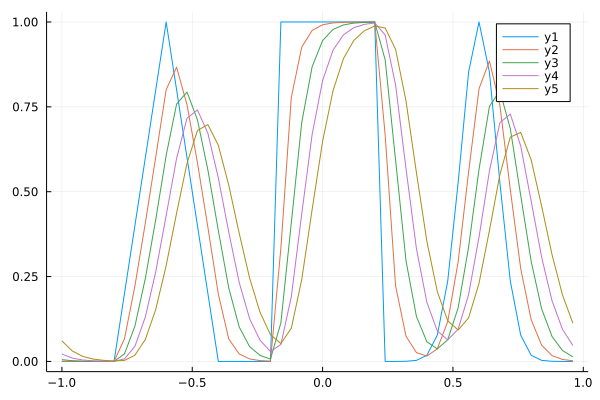

In [79]:
A = advdiff_matrix(50, kappa=0, upwind=1)
thist, uhist = ode_theta_linear(A, initial_three.(x), h=.04, theta=.5, tfinal=1.)
plot(x, uhist[:, 1:5])

* Small and large $Pe_L$, Upwind vs centered, vary $\theta$

# Spectrum of operators

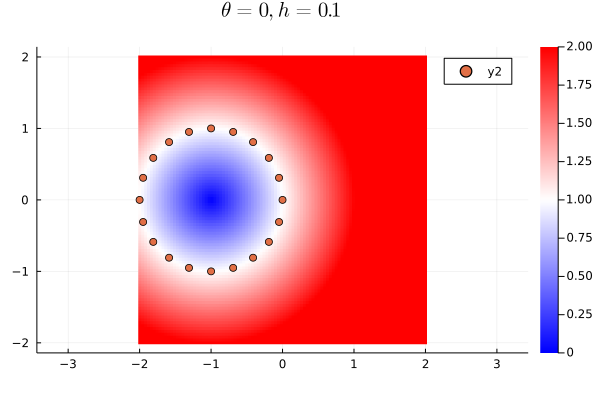

In [82]:
theta=0
kappa = 0
h = .1
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advdiff_matrix(20, kappa=kappa, upwind=1)))
scatter!(real(ev), imag(ev))

# Stability limits: CFL principle for advection

> A stable method must be capable of propagating information at least as fast as the continuous system it discretizes.

* Courant, Friedrichs, Levy (1928)
* Discrete information moves at most $\Delta x$ in time $\Delta t$ (with explicit integrator)
* Physical information moves distance $|w| \Delta t$
* "CFL number" or "Courant number"
$$ \textrm{CFL} = \frac{\Delta t |w|}{\Delta x} \le 1 $$
* What does this mean for implicit methods?

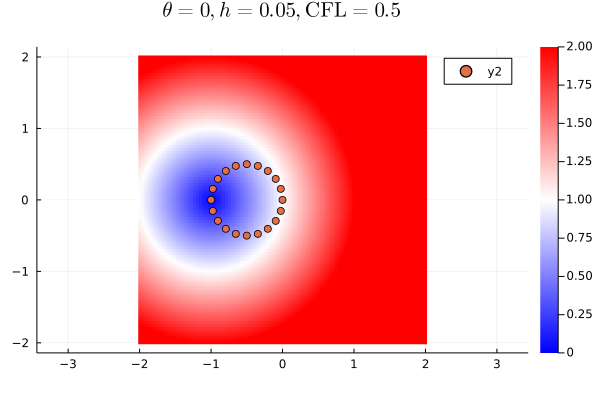

In [87]:
theta=0
n = 20
dx = 2 / n
cfl = .5
h = cfl * dx / 1

plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h, \\mathrm{CFL}=$cfl\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=0, upwind=1)))
scatter!(real(ev), imag(ev))

# Stability limits: explicit diffusion

* The diffusion operator has stencil
$$ \frac{\kappa}{(\Delta x)^2} \begin{bmatrix} 1 & -2 & 1 \end{bmatrix} $$
* Apply this to test function $e^{i\theta x}$ to get the symbol
\begin{align}
L_{\Delta x} e^{i\theta x}
&=
\frac{\kappa}{(\Delta x)^2} \Big[ e^{-i\theta\Delta x} - 2 + e^{i\theta\Delta x} \Big] e^{i\theta x} \\
&= \frac{2\kappa}{(\Delta x)^2} \underbrace{\Big[ \cos (\theta \Delta x) - 1 \Big]}_{\min = -2} e^{i\theta x}
\end{align}
* Conclude $\frac{-4 \kappa}{(\Delta x)^2} \le \lambda \le 0$, need $-2 \le h\lambda \le 0$ for Euler

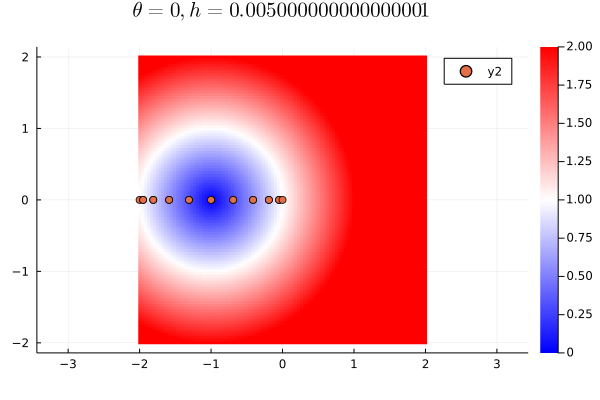

In [95]:
theta=0
n = 20
dx = 2 / n
kappa = 1
lambda_min = -4 * kappa / dx^2
h = -2 / lambda_min

plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=0)))
scatter!(real(ev), imag(ev))

# Stiffness

> Stiff equations are problems for which explicit methods don't work. (Hairer and Wanner, 2002)

* "stiff" dates to Curtiss and Hirschfelder (1952)

## Discuss: is advection-diffusion stiff?

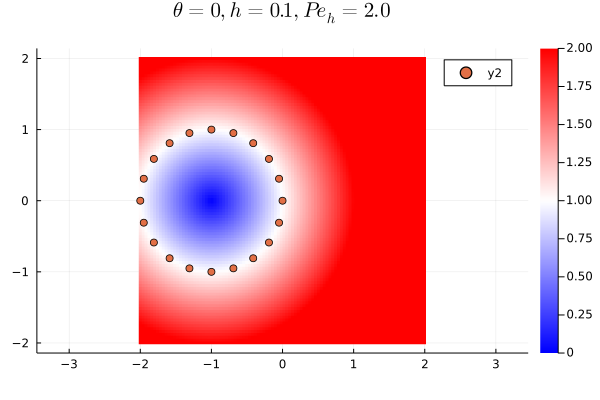

In [110]:
theta=0
n = 20
dx = 2 / n
kappa = .05
lambda_min = -4 * kappa / dx^2
cfl = 1
h = min(-2 / lambda_min, cfl * dx)

plot_stability(z -> Rz_theta(z, theta),
    "\$\\theta=$theta, h=$h, Pe_h = $(h/kappa)\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=1)))
scatter!(real(ev), imag(ev))

# Cost scaling

* Spatial discretization with error $O((\Delta x)^p)$
* Time discretization with error $O((\Delta t)^q)$